- 스트레스 안받음: 3-4, 9-10번째 타임스탬프 사이 구간 [0]
- 스트레스 약하게 받음: 5-6번째 타임스탬프 사이 구간 [1]
- 스트레스 강하게 받음: 11-12번째 타임스탬프 사이 구간 [2] 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
import tensorflow as tf
import datetime
warnings.filterwarnings(action='ignore')

## 데이터 전처리 함수 정의

In [2]:
def Data(bvp,gsr,tmp,text):
    
    bvp.Time=bvp.Time.astype('int64')
    gsr.Time=gsr.Time.astype('int64')
    tmp.Time=tmp.Time.astype('int64')
    Time_range=text.astype('int64')
    
    bvp_mean=pd.DataFrame(bvp.groupby('Time')['BVP'].mean())
    gsr_mean=pd.DataFrame(gsr.groupby('Time')['GSR'].mean())
    tmp_mean=pd.DataFrame(tmp.groupby('Time')['TMP'].mean())

    res=pd.concat([bvp_mean,gsr_mean,tmp_mean],axis=1)
    res=res.dropna()
    
    res34=res[(Time_range.iloc[3][0]<=res.index) & (Time_range.iloc[4][0]>=res.index)]
    res34['Stress']=0
    res910=res[(Time_range.iloc[9][0]<=res.index) & (Time_range.iloc[10][0]>=res.index)]
    res910['Stress']=0
    res56=res[(Time_range.iloc[5][0]<=res.index) & (Time_range.iloc[6][0]>=res.index)]
    res56['Stress']=1
    res1112=res[(Time_range.iloc[11][0]<=res.index) & (Time_range.iloc[12][0]>=res.index)]
    res1112['Stress']=2

    fin=pd.concat([res34,res910,res56,res1112],axis=0,ignore_index=True)
    
    return fin

## 전체 데이터 병합

In [3]:
path='test/test/'
lis=[]
for i in range(1,51):
    try:
     
        bvp=pd.read_csv(path+f'S{i}_E_bvp.csv',names=['Time','BVP'])
        gsr=pd.read_csv(path+f'S{i}_E_gsr.csv',names=['Time','GSR'])
        tmp=pd.read_csv(path+f'S{i}_E_tmp.csv',names=['Time','TMP'])
        text=pd.read_csv(path+f'S{i}_time.txt',names=['Time'])
    
        df=Data(bvp,gsr,tmp,text)
        lis.append(df)
        
    except:
        pass
vital_sign=pd.concat(lis,axis=0,ignore_index=True)

In [4]:
vital_sign.drop_duplicates(inplace=True)

In [27]:
vital_sign['Stress'].value_counts()

0    17037
2     8930
1     8638
Name: Stress, dtype: int64

## 빈도그래프

<function matplotlib.pyplot.show(*args, **kw)>

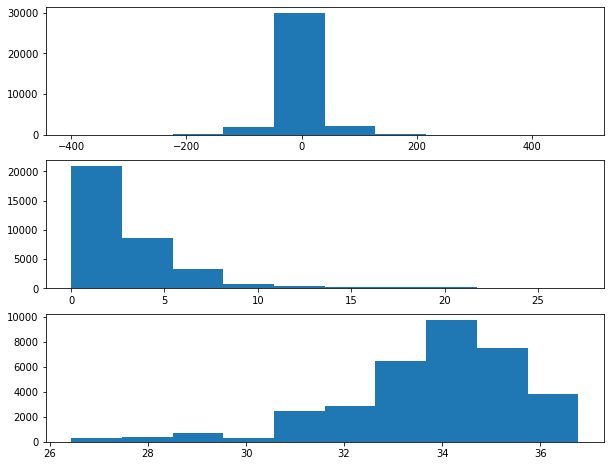

In [28]:
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.hist(vital_sign['BVP'])
plt.subplot(3,1,2)
plt.hist(vital_sign['GSR'])
plt.subplot(3,1,3)
plt.hist(vital_sign['TMP'])
plt.show

## MinMax Scaling

In [5]:
mm=MinMaxScaler()
mmdata=mm.fit_transform(vital_sign[['BVP','GSR','TMP']])
df=pd.DataFrame(mmdata,columns=['BVP','GSR','TMP'])
vital_mm=pd.concat([df,vital_sign['Stress']],axis=1)
vital_mm.to_csv('this.csv')

## 모델링

In [6]:
#minmax scailing
X=vital_mm[['BVP','GSR','TMP']]
Y=vital_mm['Stress']

# encoder =  LabelEncoder()
# y1 = encoder.fit_transform(Y)
# Y = pd.get_dummies(y1).values

In [7]:
trainX,testX,trainY,testY=train_test_split(X,Y,test_size=0.3,random_state=1129)

### xbgoost

In [9]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# 1번 2번

model=XGBClassifier()
param_grid={'booster' :['gbtree'],
                 'silent':[True],
                 'max_depth':[3,6,9,10],
                 'min_child_weight':[1,3,5],
                 'gamma':[0,3],
                 'nthread':[4],
                 'colsample_bytree':[0.5,0.8],
                 'n_estimators':[50,70],
                 'objective':['multi:softmax'],
                 'random_state':[2]}

gcv=GridSearchCV(model, param_grid=param_grid, scoring='accuracy', n_jobs=4,verbose=2)
gcv.fit(trainX.values,trainY.values)

In [63]:
print('final params', gcv.best_params_)   # 최적의 파라미터 값 출력
print('best score', gcv.best_score_)      # 최고의 점수

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   60.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed: 11.9min finished


[23:03:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


final params {'booster': 'gbtree', 'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 70, 'nthread': 4, 'objective': 'multi:softmax', 'random_state': 2, 'silent': True}
best score 0.8861413053204246


In [10]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [16]:
model=XGBClassifier(booster='gbtree', 
                    colsample_bylevel=0.8, 
                    colsample_bytree=0.8, 
                    colsample_bynode=1,
                    gamma=0, 
                    num_parallel_tree=1,
                     n_jobs=4,
                    max_depth=10, 
                    min_child_weight=3, 
                    n_estimators=70, 
                    nthread=4, 
                    objective='multi:softmax', 
                    random_state=2,
                    silent= True)
                   
                   
eval_set = [(trainX, trainY), (testX, testY)]
model.fit(trainX, trainY, early_stopping_rounds=50, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)

[09:43:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-merror:0.35916	validation_0-mlogloss:1.00803	validation_1-merror:0.40108	validation_1-mlogloss:1.02177
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-merror:0.19349	validation_0-mlogloss:0.83668	validation_1-merror:0.22645	validation_1-mlogloss:0.85815
[2]	validation_0-merror:0.19448	validation_0-mlogloss:0.77870	validation_1-merror:0.22934	validation_1-mlogloss:0.80692
[3]	validation_0-merror:0.17496	validation_0-mlogloss:0.69352	validation_1-merror:0.20256

[64]	validation_0-merror:0.04236	validation_0-mlogloss:0.19958	validation_1-merror:0.11645	validation_1-mlogloss:0.31973
[65]	validation_0-merror:0.04137	validation_0-mlogloss:0.19832	validation_1-merror:0.11626	validation_1-mlogloss:0.31979
[66]	validation_0-merror:0.04112	validation_0-mlogloss:0.19568	validation_1-merror:0.11587	validation_1-mlogloss:0.31715
[67]	validation_0-merror:0.04070	validation_0-mlogloss:0.19120	validation_1-merror:0.11414	validation_1-mlogloss:0.31260
[68]	validation_0-merror:0.03938	validation_0-mlogloss:0.18616	validation_1-merror:0.11298	validation_1-mlogloss:0.30793
[69]	validation_0-merror:0.03893	validation_0-mlogloss:0.18497	validation_1-merror:0.11279	validation_1-mlogloss:0.30739


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=70, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=2, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, silent=True, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
predY=model.predict(testX)

In [18]:
accuracy = accuracy_score(testY, predY)

In [19]:
accuracy

0.8872086303217106

In [20]:
model.save_model('XGBoost_re.json')

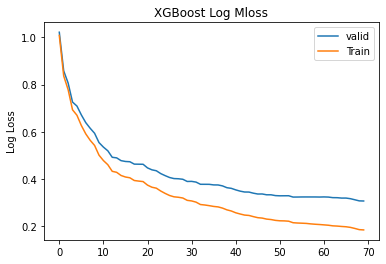

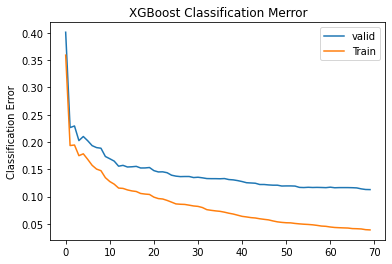

In [20]:
results = model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, results['validation_1']['mlogloss'], label='valid')
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Mloss')
plt.savefig('XGBoost Log Mloss_good.jpg')
plt.show()


fig, ax = plt.subplots()

ax.plot(x_axis, results['validation_1']['merror'], label='valid')
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Merror')
plt.savefig('XGBoost Classification Merror_good.jpg')
plt.show()


### 딥러닝

In [9]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu',input_shape=(trainX.shape[1],)))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 17,411
Trainable params: 17,411
Non-trainable params: 0
_________________________________________________________________


In [13]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [15]:
hist=model.fit(trainX,trainY,
          epochs=2000,
          callbacks=[tensorboard_callback],
          validation_data=(testX,testY),
          verbose=2)

Epoch 1/2000
757/757 - 2s - loss: 0.9021 - accuracy: 0.5806 - val_loss: 0.9009 - val_accuracy: 0.5795
Epoch 2/2000
757/757 - 1s - loss: 0.8963 - accuracy: 0.5847 - val_loss: 0.8974 - val_accuracy: 0.5917
Epoch 3/2000
757/757 - 1s - loss: 0.8909 - accuracy: 0.5918 - val_loss: 0.8971 - val_accuracy: 0.5931
Epoch 4/2000
757/757 - 2s - loss: 0.8868 - accuracy: 0.5927 - val_loss: 0.8915 - val_accuracy: 0.5901
Epoch 5/2000
757/757 - 1s - loss: 0.8812 - accuracy: 0.5986 - val_loss: 0.8973 - val_accuracy: 0.5832
Epoch 6/2000
757/757 - 2s - loss: 0.8753 - accuracy: 0.6021 - val_loss: 0.8841 - val_accuracy: 0.5847
Epoch 7/2000
757/757 - 2s - loss: 0.8706 - accuracy: 0.6023 - val_loss: 0.8708 - val_accuracy: 0.5972
Epoch 8/2000
757/757 - 2s - loss: 0.8632 - accuracy: 0.6095 - val_loss: 0.8683 - val_accuracy: 0.6153
Epoch 9/2000
757/757 - 2s - loss: 0.8578 - accuracy: 0.6119 - val_loss: 0.8642 - val_accuracy: 0.6098
Epoch 10/2000
757/757 - 2s - loss: 0.8537 - accuracy: 0.6145 - val_loss: 0.8572 - 

Epoch 79/2000
757/757 - 1s - loss: 0.6439 - accuracy: 0.7072 - val_loss: 0.6524 - val_accuracy: 0.7003
Epoch 80/2000
757/757 - 1s - loss: 0.6416 - accuracy: 0.7061 - val_loss: 0.6577 - val_accuracy: 0.6982
Epoch 81/2000
757/757 - 1s - loss: 0.6422 - accuracy: 0.7056 - val_loss: 0.6432 - val_accuracy: 0.7078
Epoch 82/2000
757/757 - 1s - loss: 0.6393 - accuracy: 0.7086 - val_loss: 0.6424 - val_accuracy: 0.7043
Epoch 83/2000
757/757 - 1s - loss: 0.6391 - accuracy: 0.7061 - val_loss: 0.6316 - val_accuracy: 0.7225
Epoch 84/2000
757/757 - 1s - loss: 0.6377 - accuracy: 0.7081 - val_loss: 0.6466 - val_accuracy: 0.7053
Epoch 85/2000
757/757 - 1s - loss: 0.6372 - accuracy: 0.7091 - val_loss: 0.6429 - val_accuracy: 0.7090
Epoch 86/2000
757/757 - 1s - loss: 0.6329 - accuracy: 0.7110 - val_loss: 0.6442 - val_accuracy: 0.7004
Epoch 87/2000
757/757 - 1s - loss: 0.6339 - accuracy: 0.7113 - val_loss: 0.6349 - val_accuracy: 0.7189
Epoch 88/2000
757/757 - 2s - loss: 0.6330 - accuracy: 0.7090 - val_loss: 

Epoch 158/2000
757/757 - 1s - loss: 0.5666 - accuracy: 0.7469 - val_loss: 0.5824 - val_accuracy: 0.7368
Epoch 159/2000
757/757 - 1s - loss: 0.5650 - accuracy: 0.7450 - val_loss: 0.5631 - val_accuracy: 0.7444
Epoch 160/2000
757/757 - 1s - loss: 0.5657 - accuracy: 0.7473 - val_loss: 0.5651 - val_accuracy: 0.7491
Epoch 161/2000
757/757 - 1s - loss: 0.5650 - accuracy: 0.7466 - val_loss: 0.5752 - val_accuracy: 0.7443
Epoch 162/2000
757/757 - 1s - loss: 0.5627 - accuracy: 0.7455 - val_loss: 0.5540 - val_accuracy: 0.7531
Epoch 163/2000
757/757 - 1s - loss: 0.5605 - accuracy: 0.7471 - val_loss: 0.5571 - val_accuracy: 0.7474
Epoch 164/2000
757/757 - 1s - loss: 0.5628 - accuracy: 0.7481 - val_loss: 0.5764 - val_accuracy: 0.7434
Epoch 165/2000
757/757 - 1s - loss: 0.5618 - accuracy: 0.7503 - val_loss: 0.5775 - val_accuracy: 0.7374
Epoch 166/2000
757/757 - 1s - loss: 0.5628 - accuracy: 0.7499 - val_loss: 0.6327 - val_accuracy: 0.7143
Epoch 167/2000
757/757 - 1s - loss: 0.5622 - accuracy: 0.7495 - 

Epoch 237/2000
757/757 - 2s - loss: 0.5214 - accuracy: 0.7694 - val_loss: 0.5149 - val_accuracy: 0.7752
Epoch 238/2000
757/757 - 1s - loss: 0.5243 - accuracy: 0.7672 - val_loss: 0.5343 - val_accuracy: 0.7616
Epoch 239/2000
757/757 - 1s - loss: 0.5255 - accuracy: 0.7668 - val_loss: 0.5335 - val_accuracy: 0.7674
Epoch 240/2000
757/757 - 1s - loss: 0.5239 - accuracy: 0.7684 - val_loss: 0.5228 - val_accuracy: 0.7698
Epoch 241/2000
757/757 - 1s - loss: 0.5204 - accuracy: 0.7712 - val_loss: 0.5349 - val_accuracy: 0.7645
Epoch 242/2000
757/757 - 1s - loss: 0.5223 - accuracy: 0.7691 - val_loss: 0.5253 - val_accuracy: 0.7657
Epoch 243/2000
757/757 - 1s - loss: 0.5290 - accuracy: 0.7677 - val_loss: 0.5295 - val_accuracy: 0.7654
Epoch 244/2000
757/757 - 1s - loss: 0.5209 - accuracy: 0.7708 - val_loss: 0.5390 - val_accuracy: 0.7596
Epoch 245/2000
757/757 - 1s - loss: 0.5204 - accuracy: 0.7705 - val_loss: 0.5163 - val_accuracy: 0.7719
Epoch 246/2000
757/757 - 1s - loss: 0.5207 - accuracy: 0.7677 - 

Epoch 316/2000
757/757 - 1s - loss: 0.5000 - accuracy: 0.7835 - val_loss: 0.5071 - val_accuracy: 0.7768
Epoch 317/2000
757/757 - 1s - loss: 0.4955 - accuracy: 0.7833 - val_loss: 0.5272 - val_accuracy: 0.7664
Epoch 318/2000
757/757 - 1s - loss: 0.4968 - accuracy: 0.7820 - val_loss: 0.5406 - val_accuracy: 0.7601
Epoch 319/2000
757/757 - 1s - loss: 0.4956 - accuracy: 0.7827 - val_loss: 0.4939 - val_accuracy: 0.7823
Epoch 320/2000
757/757 - 1s - loss: 0.4964 - accuracy: 0.7832 - val_loss: 0.5063 - val_accuracy: 0.7788
Epoch 321/2000
757/757 - 1s - loss: 0.4960 - accuracy: 0.7839 - val_loss: 0.5008 - val_accuracy: 0.7850
Epoch 322/2000
757/757 - 1s - loss: 0.4980 - accuracy: 0.7829 - val_loss: 0.5011 - val_accuracy: 0.7827
Epoch 323/2000
757/757 - 1s - loss: 0.4907 - accuracy: 0.7838 - val_loss: 0.4934 - val_accuracy: 0.7827
Epoch 324/2000
757/757 - 1s - loss: 0.4940 - accuracy: 0.7825 - val_loss: 0.4954 - val_accuracy: 0.7863
Epoch 325/2000
757/757 - 1s - loss: 0.4999 - accuracy: 0.7789 - 

Epoch 395/2000
757/757 - 1s - loss: 0.4746 - accuracy: 0.7936 - val_loss: 0.4760 - val_accuracy: 0.7899
Epoch 396/2000
757/757 - 1s - loss: 0.4739 - accuracy: 0.7921 - val_loss: 0.4803 - val_accuracy: 0.7918
Epoch 397/2000
757/757 - 1s - loss: 0.4744 - accuracy: 0.7923 - val_loss: 0.4865 - val_accuracy: 0.7867
Epoch 398/2000
757/757 - 1s - loss: 0.4757 - accuracy: 0.7939 - val_loss: 0.4791 - val_accuracy: 0.7936
Epoch 399/2000
757/757 - 1s - loss: 0.4765 - accuracy: 0.7905 - val_loss: 0.4848 - val_accuracy: 0.7912
Epoch 400/2000
757/757 - 1s - loss: 0.4729 - accuracy: 0.7926 - val_loss: 0.4782 - val_accuracy: 0.7902
Epoch 401/2000
757/757 - 1s - loss: 0.4767 - accuracy: 0.7898 - val_loss: 0.4986 - val_accuracy: 0.7811
Epoch 402/2000
757/757 - 1s - loss: 0.4790 - accuracy: 0.7917 - val_loss: 0.4944 - val_accuracy: 0.7799
Epoch 403/2000
757/757 - 1s - loss: 0.4732 - accuracy: 0.7940 - val_loss: 0.4725 - val_accuracy: 0.7914
Epoch 404/2000
757/757 - 1s - loss: 0.4733 - accuracy: 0.7939 - 

Epoch 474/2000
757/757 - 1s - loss: 0.4570 - accuracy: 0.8002 - val_loss: 0.4618 - val_accuracy: 0.8045
Epoch 475/2000
757/757 - 1s - loss: 0.4566 - accuracy: 0.8039 - val_loss: 0.4826 - val_accuracy: 0.7867
Epoch 476/2000
757/757 - 1s - loss: 0.4583 - accuracy: 0.8012 - val_loss: 0.4551 - val_accuracy: 0.8012
Epoch 477/2000
757/757 - 1s - loss: 0.4550 - accuracy: 0.8035 - val_loss: 0.4682 - val_accuracy: 0.7959
Epoch 478/2000
757/757 - 1s - loss: 0.4626 - accuracy: 0.8004 - val_loss: 0.4509 - val_accuracy: 0.8033
Epoch 479/2000
757/757 - 1s - loss: 0.4563 - accuracy: 0.8026 - val_loss: 0.4636 - val_accuracy: 0.8031
Epoch 480/2000
757/757 - 1s - loss: 0.4574 - accuracy: 0.8012 - val_loss: 0.4496 - val_accuracy: 0.8098
Epoch 481/2000
757/757 - 1s - loss: 0.4540 - accuracy: 0.8018 - val_loss: 0.4765 - val_accuracy: 0.7881
Epoch 482/2000
757/757 - 1s - loss: 0.4535 - accuracy: 0.8032 - val_loss: 0.4727 - val_accuracy: 0.7925
Epoch 483/2000
757/757 - 1s - loss: 0.4559 - accuracy: 0.8006 - 

Epoch 553/2000
757/757 - 1s - loss: 0.4417 - accuracy: 0.8090 - val_loss: 0.4525 - val_accuracy: 0.8081
Epoch 554/2000
757/757 - 1s - loss: 0.4415 - accuracy: 0.8074 - val_loss: 0.4553 - val_accuracy: 0.7935
Epoch 555/2000
757/757 - 1s - loss: 0.4440 - accuracy: 0.8060 - val_loss: 0.4404 - val_accuracy: 0.8103
Epoch 556/2000
757/757 - 1s - loss: 0.4399 - accuracy: 0.8086 - val_loss: 0.4797 - val_accuracy: 0.7835
Epoch 557/2000
757/757 - 1s - loss: 0.4436 - accuracy: 0.8079 - val_loss: 0.4495 - val_accuracy: 0.8013
Epoch 558/2000
757/757 - 1s - loss: 0.4371 - accuracy: 0.8108 - val_loss: 0.4597 - val_accuracy: 0.7959
Epoch 559/2000
757/757 - 2s - loss: 0.4452 - accuracy: 0.8091 - val_loss: 0.4584 - val_accuracy: 0.7961
Epoch 560/2000
757/757 - 2s - loss: 0.4453 - accuracy: 0.8065 - val_loss: 0.4479 - val_accuracy: 0.8040
Epoch 561/2000
757/757 - 2s - loss: 0.4428 - accuracy: 0.8083 - val_loss: 0.4529 - val_accuracy: 0.7978
Epoch 562/2000
757/757 - 1s - loss: 0.4452 - accuracy: 0.8075 - 

Epoch 632/2000
757/757 - 1s - loss: 0.4320 - accuracy: 0.8149 - val_loss: 0.4277 - val_accuracy: 0.8145
Epoch 633/2000
757/757 - 1s - loss: 0.4319 - accuracy: 0.8122 - val_loss: 0.4553 - val_accuracy: 0.7957
Epoch 634/2000
757/757 - 1s - loss: 0.4323 - accuracy: 0.8150 - val_loss: 0.4713 - val_accuracy: 0.7962
Epoch 635/2000
757/757 - 1s - loss: 0.4356 - accuracy: 0.8106 - val_loss: 0.4627 - val_accuracy: 0.7954
Epoch 636/2000
757/757 - 1s - loss: 0.4312 - accuracy: 0.8148 - val_loss: 0.4315 - val_accuracy: 0.8138
Epoch 637/2000
757/757 - 1s - loss: 0.4304 - accuracy: 0.8119 - val_loss: 0.4426 - val_accuracy: 0.8071
Epoch 638/2000
757/757 - 1s - loss: 0.4320 - accuracy: 0.8149 - val_loss: 0.4412 - val_accuracy: 0.8083
Epoch 639/2000
757/757 - 1s - loss: 0.4313 - accuracy: 0.8138 - val_loss: 0.4555 - val_accuracy: 0.8035
Epoch 640/2000
757/757 - 1s - loss: 0.4275 - accuracy: 0.8143 - val_loss: 0.4917 - val_accuracy: 0.7791
Epoch 641/2000
757/757 - 1s - loss: 0.4289 - accuracy: 0.8128 - 

Epoch 711/2000
757/757 - 1s - loss: 0.4184 - accuracy: 0.8189 - val_loss: 0.4224 - val_accuracy: 0.8169
Epoch 712/2000
757/757 - 1s - loss: 0.4209 - accuracy: 0.8172 - val_loss: 0.4294 - val_accuracy: 0.8098
Epoch 713/2000
757/757 - 1s - loss: 0.4211 - accuracy: 0.8161 - val_loss: 0.4240 - val_accuracy: 0.8197
Epoch 714/2000
757/757 - 1s - loss: 0.4226 - accuracy: 0.8171 - val_loss: 0.4302 - val_accuracy: 0.8096
Epoch 715/2000
757/757 - 1s - loss: 0.4168 - accuracy: 0.8188 - val_loss: 0.4328 - val_accuracy: 0.8089
Epoch 716/2000
757/757 - 1s - loss: 0.4238 - accuracy: 0.8166 - val_loss: 0.4290 - val_accuracy: 0.8100
Epoch 717/2000
757/757 - 1s - loss: 0.4199 - accuracy: 0.8173 - val_loss: 0.4662 - val_accuracy: 0.7923
Epoch 718/2000
757/757 - 1s - loss: 0.4197 - accuracy: 0.8195 - val_loss: 0.4299 - val_accuracy: 0.8091
Epoch 719/2000
757/757 - 1s - loss: 0.4215 - accuracy: 0.8175 - val_loss: 0.4433 - val_accuracy: 0.8027
Epoch 720/2000
757/757 - 1s - loss: 0.4195 - accuracy: 0.8189 - 

Epoch 790/2000
757/757 - 1s - loss: 0.4119 - accuracy: 0.8217 - val_loss: 0.4271 - val_accuracy: 0.8151
Epoch 791/2000
757/757 - 1s - loss: 0.4102 - accuracy: 0.8217 - val_loss: 0.4340 - val_accuracy: 0.8008
Epoch 792/2000
757/757 - 1s - loss: 0.4081 - accuracy: 0.8234 - val_loss: 0.4333 - val_accuracy: 0.8058
Epoch 793/2000
757/757 - 1s - loss: 0.4082 - accuracy: 0.8247 - val_loss: 0.4196 - val_accuracy: 0.8211
Epoch 794/2000
757/757 - 1s - loss: 0.4132 - accuracy: 0.8231 - val_loss: 0.4202 - val_accuracy: 0.8113
Epoch 795/2000
757/757 - 2s - loss: 0.4110 - accuracy: 0.8204 - val_loss: 0.4361 - val_accuracy: 0.8141
Epoch 796/2000
757/757 - 1s - loss: 0.4129 - accuracy: 0.8231 - val_loss: 0.4384 - val_accuracy: 0.8115
Epoch 797/2000
757/757 - 2s - loss: 0.4089 - accuracy: 0.8229 - val_loss: 0.4292 - val_accuracy: 0.8116
Epoch 798/2000
757/757 - 1s - loss: 0.4122 - accuracy: 0.8215 - val_loss: 0.4166 - val_accuracy: 0.8172
Epoch 799/2000
757/757 - 1s - loss: 0.4091 - accuracy: 0.8228 - 

Epoch 869/2000
757/757 - 1s - loss: 0.4036 - accuracy: 0.8271 - val_loss: 0.4232 - val_accuracy: 0.8189
Epoch 870/2000
757/757 - 1s - loss: 0.4055 - accuracy: 0.8263 - val_loss: 0.4032 - val_accuracy: 0.8305
Epoch 871/2000
757/757 - 1s - loss: 0.4022 - accuracy: 0.8243 - val_loss: 0.4389 - val_accuracy: 0.8128
Epoch 872/2000
757/757 - 1s - loss: 0.4052 - accuracy: 0.8253 - val_loss: 0.4512 - val_accuracy: 0.8197
Epoch 873/2000
757/757 - 1s - loss: 0.4015 - accuracy: 0.8246 - val_loss: 0.4086 - val_accuracy: 0.8224
Epoch 874/2000
757/757 - 1s - loss: 0.3987 - accuracy: 0.8274 - val_loss: 0.4065 - val_accuracy: 0.8246
Epoch 875/2000
757/757 - 1s - loss: 0.4037 - accuracy: 0.8277 - val_loss: 0.4092 - val_accuracy: 0.8239
Epoch 876/2000
757/757 - 1s - loss: 0.4026 - accuracy: 0.8274 - val_loss: 0.4142 - val_accuracy: 0.8218
Epoch 877/2000
757/757 - 1s - loss: 0.3983 - accuracy: 0.8289 - val_loss: 0.4115 - val_accuracy: 0.8256
Epoch 878/2000
757/757 - 1s - loss: 0.4060 - accuracy: 0.8247 - 

Epoch 948/2000
757/757 - 1s - loss: 0.3976 - accuracy: 0.8288 - val_loss: 0.4270 - val_accuracy: 0.8122
Epoch 949/2000
757/757 - 1s - loss: 0.3983 - accuracy: 0.8273 - val_loss: 0.4177 - val_accuracy: 0.8199
Epoch 950/2000
757/757 - 1s - loss: 0.3935 - accuracy: 0.8309 - val_loss: 0.3987 - val_accuracy: 0.8324
Epoch 951/2000
757/757 - 1s - loss: 0.3997 - accuracy: 0.8306 - val_loss: 0.4124 - val_accuracy: 0.8236
Epoch 952/2000
757/757 - 1s - loss: 0.4045 - accuracy: 0.8250 - val_loss: 0.4078 - val_accuracy: 0.8266
Epoch 953/2000
757/757 - 1s - loss: 0.3973 - accuracy: 0.8299 - val_loss: 0.4877 - val_accuracy: 0.7982
Epoch 954/2000
757/757 - 1s - loss: 0.3980 - accuracy: 0.8297 - val_loss: 0.4263 - val_accuracy: 0.8279
Epoch 955/2000
757/757 - 1s - loss: 0.3987 - accuracy: 0.8288 - val_loss: 0.4802 - val_accuracy: 0.8010
Epoch 956/2000
757/757 - 1s - loss: 0.4006 - accuracy: 0.8283 - val_loss: 0.3955 - val_accuracy: 0.8294
Epoch 957/2000
757/757 - 1s - loss: 0.3943 - accuracy: 0.8328 - 

Epoch 1027/2000
757/757 - 1s - loss: 0.3942 - accuracy: 0.8301 - val_loss: 0.3931 - val_accuracy: 0.8285
Epoch 1028/2000
757/757 - 1s - loss: 0.3889 - accuracy: 0.8341 - val_loss: 0.4372 - val_accuracy: 0.8165
Epoch 1029/2000
757/757 - 1s - loss: 0.3939 - accuracy: 0.8303 - val_loss: 0.4348 - val_accuracy: 0.8066
Epoch 1030/2000
757/757 - 1s - loss: 0.3934 - accuracy: 0.8313 - val_loss: 0.3985 - val_accuracy: 0.8284
Epoch 1031/2000
757/757 - 2s - loss: 0.3898 - accuracy: 0.8316 - val_loss: 0.4115 - val_accuracy: 0.8197
Epoch 1032/2000
757/757 - 2s - loss: 0.3910 - accuracy: 0.8316 - val_loss: 0.4140 - val_accuracy: 0.8247
Epoch 1033/2000
757/757 - 1s - loss: 0.3932 - accuracy: 0.8333 - val_loss: 0.4137 - val_accuracy: 0.8218
Epoch 1034/2000
757/757 - 1s - loss: 0.3978 - accuracy: 0.8301 - val_loss: 0.4089 - val_accuracy: 0.8245
Epoch 1035/2000
757/757 - 1s - loss: 0.3896 - accuracy: 0.8316 - val_loss: 0.4217 - val_accuracy: 0.8195
Epoch 1036/2000
757/757 - 1s - loss: 0.3889 - accuracy:

757/757 - 1s - loss: 0.3975 - accuracy: 0.8334 - val_loss: 0.4006 - val_accuracy: 0.8290
Epoch 1106/2000
757/757 - 1s - loss: 0.3857 - accuracy: 0.8345 - val_loss: 0.4059 - val_accuracy: 0.8268
Epoch 1107/2000
757/757 - 2s - loss: 0.3860 - accuracy: 0.8339 - val_loss: 0.3978 - val_accuracy: 0.8276
Epoch 1108/2000
757/757 - 1s - loss: 0.3869 - accuracy: 0.8331 - val_loss: 0.4031 - val_accuracy: 0.8284
Epoch 1109/2000
757/757 - 1s - loss: 0.3872 - accuracy: 0.8359 - val_loss: 0.4122 - val_accuracy: 0.8285
Epoch 1110/2000
757/757 - 1s - loss: 0.3947 - accuracy: 0.8302 - val_loss: 0.3938 - val_accuracy: 0.8243
Epoch 1111/2000
757/757 - 1s - loss: 0.3892 - accuracy: 0.8344 - val_loss: 0.3813 - val_accuracy: 0.8416
Epoch 1112/2000
757/757 - 1s - loss: 0.3876 - accuracy: 0.8356 - val_loss: 0.4191 - val_accuracy: 0.8295
Epoch 1113/2000
757/757 - 1s - loss: 0.3896 - accuracy: 0.8338 - val_loss: 0.4183 - val_accuracy: 0.8192
Epoch 1114/2000
757/757 - 1s - loss: 0.3895 - accuracy: 0.8337 - val_lo

Epoch 1184/2000
757/757 - 1s - loss: 0.3874 - accuracy: 0.8338 - val_loss: 0.4139 - val_accuracy: 0.8294
Epoch 1185/2000
757/757 - 1s - loss: 0.3833 - accuracy: 0.8380 - val_loss: 0.4304 - val_accuracy: 0.8223
Epoch 1186/2000
757/757 - 1s - loss: 0.3814 - accuracy: 0.8363 - val_loss: 0.4125 - val_accuracy: 0.8256
Epoch 1187/2000
757/757 - 1s - loss: 0.3828 - accuracy: 0.8364 - val_loss: 0.3844 - val_accuracy: 0.8354
Epoch 1188/2000
757/757 - 1s - loss: 0.3843 - accuracy: 0.8358 - val_loss: 0.4754 - val_accuracy: 0.8170
Epoch 1189/2000
757/757 - 2s - loss: 0.3824 - accuracy: 0.8350 - val_loss: 0.4119 - val_accuracy: 0.8197
Epoch 1190/2000
757/757 - 2s - loss: 0.3833 - accuracy: 0.8347 - val_loss: 0.4413 - val_accuracy: 0.8084
Epoch 1191/2000
757/757 - 2s - loss: 0.3822 - accuracy: 0.8361 - val_loss: 0.4051 - val_accuracy: 0.8307
Epoch 1192/2000
757/757 - 2s - loss: 0.3818 - accuracy: 0.8356 - val_loss: 0.4338 - val_accuracy: 0.8189
Epoch 1193/2000
757/757 - 1s - loss: 0.3845 - accuracy:

757/757 - 2s - loss: 0.3763 - accuracy: 0.8364 - val_loss: 0.4083 - val_accuracy: 0.8191
Epoch 1263/2000
757/757 - 2s - loss: 0.3784 - accuracy: 0.8394 - val_loss: 0.3996 - val_accuracy: 0.8327
Epoch 1264/2000
757/757 - 2s - loss: 0.3835 - accuracy: 0.8398 - val_loss: 0.4108 - val_accuracy: 0.8222
Epoch 1265/2000
757/757 - 1s - loss: 0.3802 - accuracy: 0.8345 - val_loss: 0.4015 - val_accuracy: 0.8289
Epoch 1266/2000
757/757 - 1s - loss: 0.3766 - accuracy: 0.8380 - val_loss: 0.3923 - val_accuracy: 0.8311
Epoch 1267/2000
757/757 - 1s - loss: 0.3776 - accuracy: 0.8388 - val_loss: 0.4123 - val_accuracy: 0.8249
Epoch 1268/2000
757/757 - 1s - loss: 0.3763 - accuracy: 0.8367 - val_loss: 0.3973 - val_accuracy: 0.8282
Epoch 1269/2000
757/757 - 1s - loss: 0.3762 - accuracy: 0.8371 - val_loss: 0.4307 - val_accuracy: 0.8169
Epoch 1270/2000
757/757 - 1s - loss: 0.3807 - accuracy: 0.8396 - val_loss: 0.4164 - val_accuracy: 0.8228
Epoch 1271/2000
757/757 - 1s - loss: 0.3767 - accuracy: 0.8371 - val_lo

Epoch 1341/2000
757/757 - 1s - loss: 0.3803 - accuracy: 0.8367 - val_loss: 0.4029 - val_accuracy: 0.8349
Epoch 1342/2000
757/757 - 1s - loss: 0.3755 - accuracy: 0.8407 - val_loss: 0.3880 - val_accuracy: 0.8336
Epoch 1343/2000
757/757 - 1s - loss: 0.3751 - accuracy: 0.8410 - val_loss: 0.3827 - val_accuracy: 0.8434
Epoch 1344/2000
757/757 - 1s - loss: 0.3771 - accuracy: 0.8380 - val_loss: 0.3936 - val_accuracy: 0.8441
Epoch 1345/2000
757/757 - 1s - loss: 0.3816 - accuracy: 0.8382 - val_loss: 0.3999 - val_accuracy: 0.8344
Epoch 1346/2000
757/757 - 1s - loss: 0.3773 - accuracy: 0.8390 - val_loss: 0.4107 - val_accuracy: 0.8181
Epoch 1347/2000
757/757 - 1s - loss: 0.3722 - accuracy: 0.8398 - val_loss: 0.4154 - val_accuracy: 0.8236
Epoch 1348/2000
757/757 - 1s - loss: 0.3757 - accuracy: 0.8377 - val_loss: 0.4124 - val_accuracy: 0.8404
Epoch 1349/2000
757/757 - 1s - loss: 0.3740 - accuracy: 0.8407 - val_loss: 0.3886 - val_accuracy: 0.8389
Epoch 1350/2000
757/757 - 1s - loss: 0.3764 - accuracy:

757/757 - 1s - loss: 0.3705 - accuracy: 0.8409 - val_loss: 0.4068 - val_accuracy: 0.8293
Epoch 1420/2000
757/757 - 1s - loss: 0.3707 - accuracy: 0.8413 - val_loss: 0.4183 - val_accuracy: 0.8200
Epoch 1421/2000
757/757 - 1s - loss: 0.3733 - accuracy: 0.8397 - val_loss: 0.4471 - val_accuracy: 0.8121
Epoch 1422/2000
757/757 - 1s - loss: 0.3734 - accuracy: 0.8398 - val_loss: 0.3756 - val_accuracy: 0.8418
Epoch 1423/2000
757/757 - 1s - loss: 0.3723 - accuracy: 0.8420 - val_loss: 0.4120 - val_accuracy: 0.8298
Epoch 1424/2000
757/757 - 1s - loss: 0.3701 - accuracy: 0.8420 - val_loss: 0.3836 - val_accuracy: 0.8411
Epoch 1425/2000
757/757 - 1s - loss: 0.3716 - accuracy: 0.8419 - val_loss: 0.3892 - val_accuracy: 0.8320
Epoch 1426/2000
757/757 - 1s - loss: 0.3738 - accuracy: 0.8373 - val_loss: 0.4382 - val_accuracy: 0.8175
Epoch 1427/2000
757/757 - 1s - loss: 0.3701 - accuracy: 0.8399 - val_loss: 0.3998 - val_accuracy: 0.8264
Epoch 1428/2000
757/757 - 1s - loss: 0.3692 - accuracy: 0.8400 - val_lo

Epoch 1498/2000
757/757 - 1s - loss: 0.3768 - accuracy: 0.8398 - val_loss: 0.4357 - val_accuracy: 0.8221
Epoch 1499/2000
757/757 - 1s - loss: 0.3692 - accuracy: 0.8399 - val_loss: 0.3813 - val_accuracy: 0.8410
Epoch 1500/2000
757/757 - 1s - loss: 0.3667 - accuracy: 0.8417 - val_loss: 0.4151 - val_accuracy: 0.8179
Epoch 1501/2000
757/757 - 1s - loss: 0.3701 - accuracy: 0.8416 - val_loss: 0.3862 - val_accuracy: 0.8360
Epoch 1502/2000
757/757 - 1s - loss: 0.3665 - accuracy: 0.8423 - val_loss: 0.3714 - val_accuracy: 0.8422
Epoch 1503/2000
757/757 - 1s - loss: 0.3761 - accuracy: 0.8407 - val_loss: 0.4038 - val_accuracy: 0.8384
Epoch 1504/2000
757/757 - 1s - loss: 0.3676 - accuracy: 0.8435 - val_loss: 0.3962 - val_accuracy: 0.8304
Epoch 1505/2000
757/757 - 2s - loss: 0.3694 - accuracy: 0.8427 - val_loss: 0.3955 - val_accuracy: 0.8331
Epoch 1506/2000
757/757 - 1s - loss: 0.3753 - accuracy: 0.8408 - val_loss: 0.4021 - val_accuracy: 0.8355
Epoch 1507/2000
757/757 - 1s - loss: 0.3674 - accuracy:

757/757 - 1s - loss: 0.3697 - accuracy: 0.8438 - val_loss: 0.4283 - val_accuracy: 0.8267
Epoch 1577/2000
757/757 - 1s - loss: 0.3734 - accuracy: 0.8390 - val_loss: 0.3866 - val_accuracy: 0.8377
Epoch 1578/2000
757/757 - 2s - loss: 0.3676 - accuracy: 0.8433 - val_loss: 0.3883 - val_accuracy: 0.8324
Epoch 1579/2000
757/757 - 1s - loss: 0.3663 - accuracy: 0.8433 - val_loss: 0.4091 - val_accuracy: 0.8306
Epoch 1580/2000
757/757 - 1s - loss: 0.3675 - accuracy: 0.8418 - val_loss: 0.4079 - val_accuracy: 0.8321
Epoch 1581/2000
757/757 - 1s - loss: 0.3669 - accuracy: 0.8425 - val_loss: 0.3848 - val_accuracy: 0.8336
Epoch 1582/2000
757/757 - 2s - loss: 0.3675 - accuracy: 0.8413 - val_loss: 0.3902 - val_accuracy: 0.8331
Epoch 1583/2000
757/757 - 1s - loss: 0.3673 - accuracy: 0.8427 - val_loss: 0.3769 - val_accuracy: 0.8407
Epoch 1584/2000
757/757 - 1s - loss: 0.3660 - accuracy: 0.8437 - val_loss: 0.3958 - val_accuracy: 0.8321
Epoch 1585/2000
757/757 - 1s - loss: 0.3689 - accuracy: 0.8442 - val_lo

Epoch 1655/2000
757/757 - 1s - loss: 0.3672 - accuracy: 0.8447 - val_loss: 0.4313 - val_accuracy: 0.8286
Epoch 1656/2000
757/757 - 1s - loss: 0.3629 - accuracy: 0.8442 - val_loss: 0.3875 - val_accuracy: 0.8383
Epoch 1657/2000
757/757 - 1s - loss: 0.3660 - accuracy: 0.8443 - val_loss: 0.3839 - val_accuracy: 0.8409
Epoch 1658/2000
757/757 - 1s - loss: 0.3605 - accuracy: 0.8483 - val_loss: 0.3951 - val_accuracy: 0.8407
Epoch 1659/2000
757/757 - 1s - loss: 0.3668 - accuracy: 0.8408 - val_loss: 0.3729 - val_accuracy: 0.8472
Epoch 1660/2000
757/757 - 1s - loss: 0.3659 - accuracy: 0.8447 - val_loss: 0.4011 - val_accuracy: 0.8366
Epoch 1661/2000
757/757 - 1s - loss: 0.3675 - accuracy: 0.8442 - val_loss: 0.3822 - val_accuracy: 0.8387
Epoch 1662/2000
757/757 - 1s - loss: 0.3727 - accuracy: 0.8416 - val_loss: 0.4200 - val_accuracy: 0.8132
Epoch 1663/2000
757/757 - 1s - loss: 0.3670 - accuracy: 0.8428 - val_loss: 0.4054 - val_accuracy: 0.8409
Epoch 1664/2000
757/757 - 1s - loss: 0.3647 - accuracy:

757/757 - 1s - loss: 0.3644 - accuracy: 0.8451 - val_loss: 0.3914 - val_accuracy: 0.8325
Epoch 1734/2000
757/757 - 1s - loss: 0.3615 - accuracy: 0.8451 - val_loss: 0.3963 - val_accuracy: 0.8314
Epoch 1735/2000
757/757 - 1s - loss: 0.3638 - accuracy: 0.8454 - val_loss: 0.3874 - val_accuracy: 0.8387
Epoch 1736/2000
757/757 - 1s - loss: 0.3602 - accuracy: 0.8448 - val_loss: 0.4057 - val_accuracy: 0.8289
Epoch 1737/2000
757/757 - 1s - loss: 0.3746 - accuracy: 0.8398 - val_loss: 0.4116 - val_accuracy: 0.8309
Epoch 1738/2000
757/757 - 1s - loss: 0.3651 - accuracy: 0.8425 - val_loss: 0.3986 - val_accuracy: 0.8344
Epoch 1739/2000
757/757 - 1s - loss: 0.3630 - accuracy: 0.8451 - val_loss: 0.3831 - val_accuracy: 0.8389
Epoch 1740/2000
757/757 - 1s - loss: 0.3659 - accuracy: 0.8425 - val_loss: 0.3810 - val_accuracy: 0.8311
Epoch 1741/2000
757/757 - 1s - loss: 0.3636 - accuracy: 0.8429 - val_loss: 0.4014 - val_accuracy: 0.8354
Epoch 1742/2000
757/757 - 1s - loss: 0.3616 - accuracy: 0.8463 - val_lo

Epoch 1812/2000
757/757 - 1s - loss: 0.3619 - accuracy: 0.8469 - val_loss: 0.4007 - val_accuracy: 0.8371
Epoch 1813/2000
757/757 - 1s - loss: 0.3649 - accuracy: 0.8449 - val_loss: 0.4026 - val_accuracy: 0.8287
Epoch 1814/2000
757/757 - 1s - loss: 0.3626 - accuracy: 0.8456 - val_loss: 0.4014 - val_accuracy: 0.8297
Epoch 1815/2000
757/757 - 1s - loss: 0.3586 - accuracy: 0.8462 - val_loss: 0.3888 - val_accuracy: 0.8363
Epoch 1816/2000
757/757 - 1s - loss: 0.3650 - accuracy: 0.8444 - val_loss: 0.4169 - val_accuracy: 0.8206
Epoch 1817/2000
757/757 - 1s - loss: 0.3635 - accuracy: 0.8424 - val_loss: 0.3918 - val_accuracy: 0.8394
Epoch 1818/2000
757/757 - 1s - loss: 0.3658 - accuracy: 0.8439 - val_loss: 0.4440 - val_accuracy: 0.8238
Epoch 1819/2000
757/757 - 1s - loss: 0.3642 - accuracy: 0.8433 - val_loss: 0.3820 - val_accuracy: 0.8386
Epoch 1820/2000
757/757 - 1s - loss: 0.3604 - accuracy: 0.8451 - val_loss: 0.3734 - val_accuracy: 0.8460
Epoch 1821/2000
757/757 - 2s - loss: 0.3589 - accuracy:

757/757 - 1s - loss: 0.3578 - accuracy: 0.8472 - val_loss: 0.4064 - val_accuracy: 0.8275
Epoch 1891/2000
757/757 - 1s - loss: 0.3581 - accuracy: 0.8463 - val_loss: 0.3915 - val_accuracy: 0.8355
Epoch 1892/2000
757/757 - 1s - loss: 0.3610 - accuracy: 0.8470 - val_loss: 0.3767 - val_accuracy: 0.8403
Epoch 1893/2000
757/757 - 1s - loss: 0.3610 - accuracy: 0.8469 - val_loss: 0.3772 - val_accuracy: 0.8438
Epoch 1894/2000
757/757 - 1s - loss: 0.3560 - accuracy: 0.8473 - val_loss: 0.3983 - val_accuracy: 0.8360
Epoch 1895/2000
757/757 - 1s - loss: 0.3562 - accuracy: 0.8485 - val_loss: 0.3853 - val_accuracy: 0.8439
Epoch 1896/2000
757/757 - 1s - loss: 0.3564 - accuracy: 0.8479 - val_loss: 0.3952 - val_accuracy: 0.8299
Epoch 1897/2000
757/757 - 1s - loss: 0.3518 - accuracy: 0.8498 - val_loss: 0.3901 - val_accuracy: 0.8420
Epoch 1898/2000
757/757 - 1s - loss: 0.3637 - accuracy: 0.8446 - val_loss: 0.3930 - val_accuracy: 0.8334
Epoch 1899/2000
757/757 - 1s - loss: 0.3586 - accuracy: 0.8459 - val_lo

Epoch 1969/2000
757/757 - 1s - loss: 0.3565 - accuracy: 0.8465 - val_loss: 0.4058 - val_accuracy: 0.8338
Epoch 1970/2000
757/757 - 1s - loss: 0.3542 - accuracy: 0.8473 - val_loss: 0.3730 - val_accuracy: 0.8451
Epoch 1971/2000
757/757 - 1s - loss: 0.3539 - accuracy: 0.8481 - val_loss: 0.3888 - val_accuracy: 0.8325
Epoch 1972/2000
757/757 - 1s - loss: 0.3583 - accuracy: 0.8491 - val_loss: 0.3676 - val_accuracy: 0.8441
Epoch 1973/2000
757/757 - 1s - loss: 0.3559 - accuracy: 0.8477 - val_loss: 0.4055 - val_accuracy: 0.8307
Epoch 1974/2000
757/757 - 1s - loss: 0.3555 - accuracy: 0.8475 - val_loss: 0.3978 - val_accuracy: 0.8390
Epoch 1975/2000
757/757 - 1s - loss: 0.3570 - accuracy: 0.8472 - val_loss: 0.3976 - val_accuracy: 0.8286
Epoch 1976/2000
757/757 - 1s - loss: 0.3539 - accuracy: 0.8494 - val_loss: 0.3967 - val_accuracy: 0.8359
Epoch 1977/2000
757/757 - 1s - loss: 0.3577 - accuracy: 0.8471 - val_loss: 0.4193 - val_accuracy: 0.8335
Epoch 1978/2000
757/757 - 1s - loss: 0.3621 - accuracy:

In [7]:
!pip3 install tensorflow

  Using cached tensorflow-2.3.1-cp37-cp37m-win_amd64.whl (342.5 MB)


In [47]:
%reload_ext tensorboard

In [64]:
tensorboard --logdir=/logs/fit --6006

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2020-12-08 19:53:37.586087: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2020-12-08 19:53:37.586381: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--purge_orphaned_data BOOL] [--db URI] [--db_import]
                   [--inspect] [--version_tb] [--tag TAG] [--event_file PATH]
                   [--path_prefix PATH] [--window_title TEXT]
                   [--max_reload_threads COUNT] [--reload_interval SECONDS]
                   [--reload_task TYPE] [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data

In [65]:
%tensorboard --logdir /logs/fit

Reusing TensorBoard on port 6006 (pid 22508), started 0:09:30 ago. (Use '!kill 22508' to kill it.)

In [95]:
model.eavaluate(testX,testY)

325/325 [==============================] - 1s 2ms/step - loss: 0.4068 - accuracy: 0.8310


[0.40677911043167114, 0.8309574127197266]

In [ ]:
model.save('simple_classification.h5')